In [1]:
using DrWatson
quickactivate(pwd(), "LArAnalysis")
using UnROOT, FHist, CairoMakie, Distributions, DelimitedFiles, Random, Printf

In [2]:
f = ROOTFile("/data7/coherent/data/LiqAr/simulation_bo/ar40_0comp.root")
t = LazyTree(f, "CENNS", ["ev_en", "ch1_photontimes", "ch3_photontimes"]);

## CEvNS PDF Generation with Klein-Nystrand FF

### Setting up the data

First, create the histogram for `dukecevns` expected events

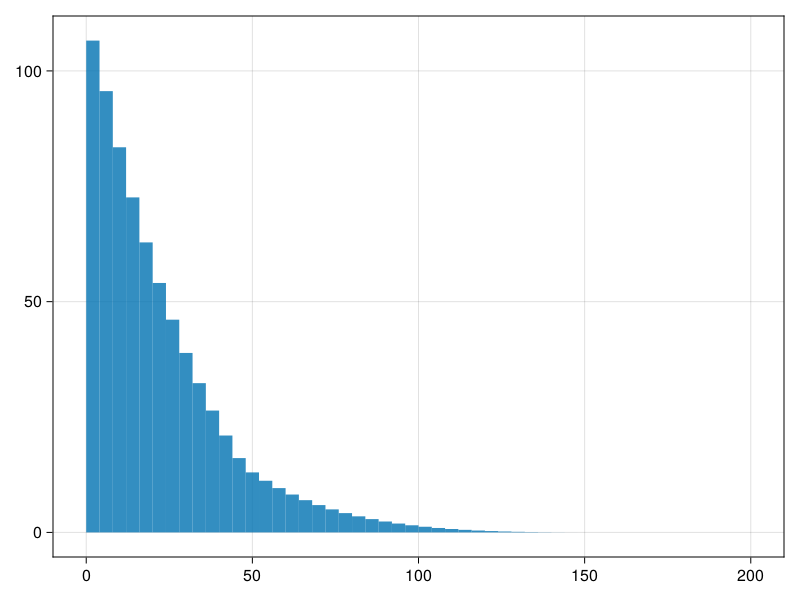

In [3]:
d = readdlm("/home/bojohn/dukecevns/out/sns_diff_rates-cenns10_ben-Ar-klein-Ar40.out")
x = d[:, 1] * 1000
y = d[:, 2] / 1000 * diff(x)[1]
h1 = Hist1D(Float64, bins=0:4:200)
push!.(h1, x, y)
hist(h1)

Then get the number of events generated for each bin

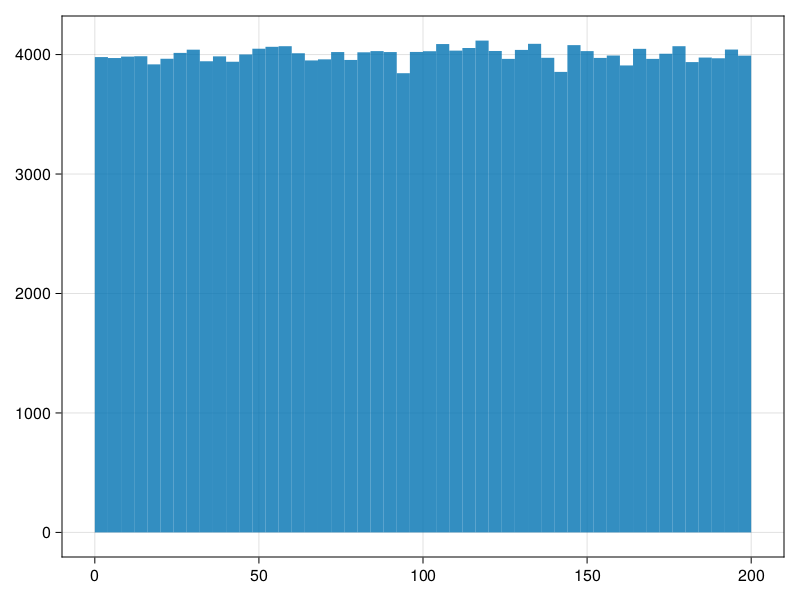

In [4]:
h2 = Hist1D(t.ev_en, 0:4:200)
hist(h2)

And construct the weight for each bin

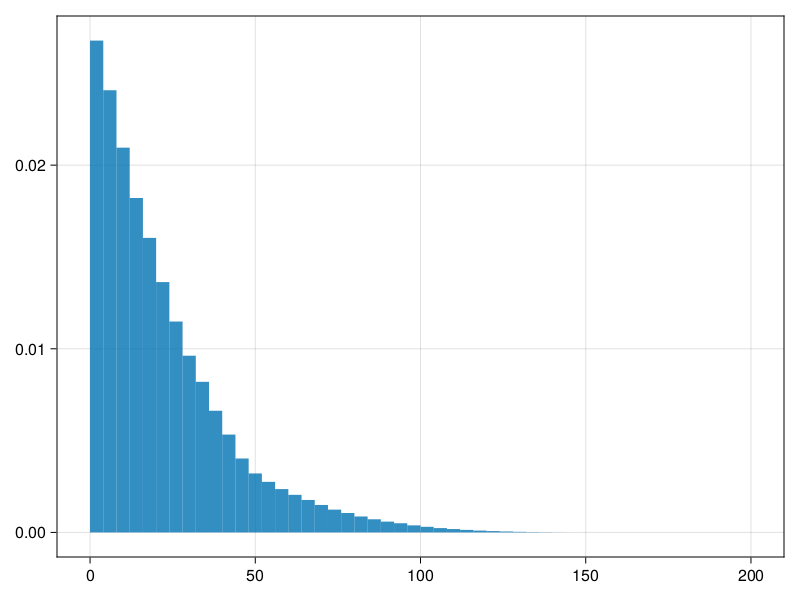

In [5]:
h3 = h1 / h2
hist(h3)

Next, create the neutrino production timing 2D histogram

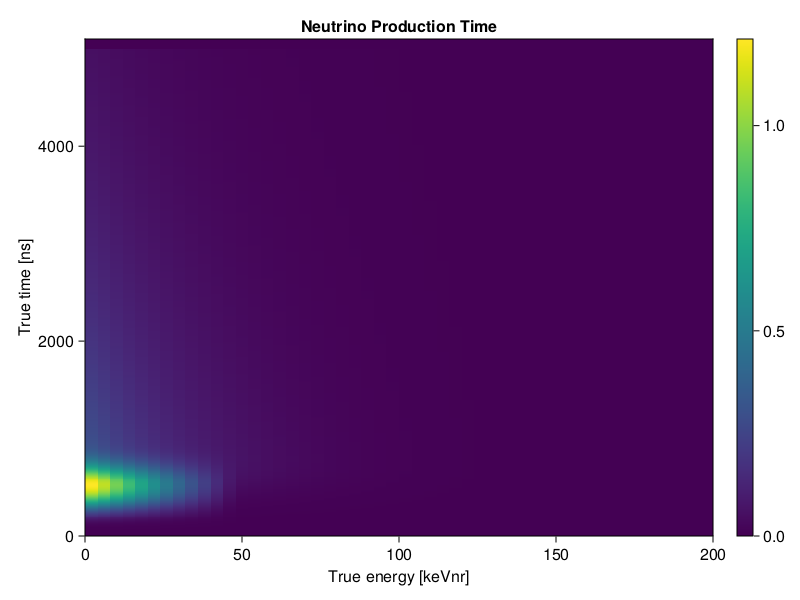

In [6]:
h4 = Hist2D(Float64, bins=(0:4:200, 0:10:5100))
for i in 0:499
  d = readdlm("/home/bojohn/dukecevns/out/sns_diff_rates-cenns10_ben_$i-Ar-klein-Ar40.out")
  x = d[:, 1] * 1000
  y = d[:, 2] / 1000 * diff(x)[1]
  h = Hist1D(Float64, bins=0:4:200)
  push!.(h, x, y)
  vals = bincounts(h)
  push!.(h4, bincenters(h), 10 * i, vals)
end
ex, ey = binedges(h4)
fig, ax, hm = heatmap(ex, ey, bincounts(h4), axis=(; title="Neutrino Production Time",
  xlabel="True energy [keVnr]", ylabel="True time [ns]"))
Colorbar(fig[:, end+1], hm)
fig

## Analysis of 4.3 PE / keVee

This is the energy conversion used in Jacob Z's analysis for Runs 1-2

In [17]:
Random.seed!(1234)

coinc = 90.0 # ns
dist = 27.5 # meters
speedoflight = 0.2998 # meters / ns
transittime_mean = 54.0 # ns
transittime_std = 2.4 / 2.335 # ns
technote_t = 212 # ns
transitd = Normal(transittime_mean, transittime_std)
econv = 5.06 # pe / keVee
d = Normal(1.0, 0.4) # smearing distribution
h5 = Hist2D(Float64, bins=(0:4:200, -100:10:10000))

for event in t
  ev_en = event.ev_en
  ch1_photons = event.ch1_photontimes
  ch3_photons = event.ch3_photontimes
  sort!(ch1_photons)
  sort!(ch3_photons)
  ch1_smeared = rand(d, length(ch1_photons))
  ch3_smeared = rand(d, length(ch3_photons))
  pes_top = sum(ch1_smeared[ch1_photons.<6000])
  pes_bot = sum(ch3_smeared[ch3_photons.<6000])
  singlets = sum(ch1_smeared[ch1_photons.<90])
  singlets += sum(ch3_smeared[ch3_photons.<90])

  f90 = singlets / (pes_top + pes_bot)

  # coincidence cut
  if length(ch1_photons) > 2 && length(ch3_photons) > 2
    t₀ = ch1_photons[1] < ch3_photons[1] ? ch1_photons[1] : ch3_photons[1]
    if abs(ch1_photons[1] - ch3_photons[1]) > 20
      continue
    end
    if ch1_photons[1] - t₀ > coinc || ch1_photons[2] - t₀ > coinc
      continue
    end
    if ch3_photons[1] - t₀ > coinc || ch3_photons[2] - t₀ > coinc
      continue
    end
  else
    continue
  end

  # F90 cut
  if f90 < 0.5 || f90 > 0.9
    continue
  end

  # tof = dist / speedoflight
  timeslice = restrict(h4, ev_en - 5.0, ev_en + 5.0) |> project(:y)
  # timeslice = projecty(h4, ev_en)
  νtime = FHist.sample(timeslice)[1] - 125.0
  # proptime = t₀
  # transittime = rand(transitd)
  # recotime = νtime + tof + proptime + transittime
  recotime = νtime + technote_t
  recoenergy = (pes_top + pes_bot) / econv
  push!(h5, recoenergy, recotime, lookup(h3, ev_en))
end

In [23]:
ex, ey = binedges(h5)
fig, ax, hm = heatmap(ex, ey, bincounts(h5), axis=(; title="CEvNS Reconstruction Klein",
  xlabel="Reconstructed energy [keVee]", ylabel="Reconstructed time [ns]"))
Colorbar(fig[:, end+1], hm)
xlims!(ax, 0, 80)
ylims!(ax, -100, 5200)
save(plotsdir("cenns10_cevns_reco.png"), fig)

CairoMakie.Screen{IMAGE}


Total events:

In [14]:
@printf "Total events: %6d" integral(h5)

Total events:    401

## Including F90 in histograms

In [21]:
Random.seed!(1234)

coinc = 90.0 # ns
dist = 27.5 # meters
speedoflight = 0.2998 # meters / ns
transittime_mean = 54.0 # ns
transittime_std = 2.4 / 2.335 # ns
transitd = Normal(transittime_mean, transittime_std)
econv = 5.06 # pe / keVee
d = Normal(1.0, 0.4) # smearing distribution
h12 = Hist3D(Float64, bins=(0:4:200, -125:10:10000, 0.5:0.01:0.9), overflow=true)
out = Float64[]

for (i, event) in enumerate(t)
  ev_en = event.ev_en
  ch1_photons = event.ch1_photontimes
  ch3_photons = event.ch3_photontimes
  sort!(ch1_photons)
  sort!(ch3_photons)
  ch1_smeared = rand(d, length(ch1_photons))
  ch3_smeared = rand(d, length(ch3_photons))
  pes_top = sum(ch1_smeared[ch1_photons.<6000])
  pes_bot = sum(ch3_smeared[ch3_photons.<6000])
  singlets = sum(ch1_smeared[ch1_photons.<90])
  singlets += sum(ch3_smeared[ch3_photons.<90])

  f90 = singlets / (pes_top + pes_bot)

  # coincidence cut
  if length(ch1_photons) > 2 && length(ch3_photons) > 2
    t₀ = ch1_photons[1] < ch3_photons[1] ? ch1_photons[1] : ch3_photons[1]
    if abs(ch1_photons[1] - ch3_photons[1]) > 20
      continue
    end
    if ch1_photons[1] - t₀ > coinc || ch1_photons[2] - t₀ > coinc
      continue
    end
    if ch3_photons[1] - t₀ > coinc || ch3_photons[2] - t₀ > coinc
      continue
    end
  else
    continue
  end

  # F90 cut
  if f90 < 0.5 || f90 > 0.9
    continue
  end

  # tof = dist / speedoflight
  timeslice = restrict(h4, ev_en - 5.0, ev_en + 5.0) |> project(:y)
  # timeslice = projecty(h4, ev_en)
  νtime = FHist.sample(timeslice)[1] - 125.0
  # proptime = t₀
  # transittime = rand(transitd)
  # recotime = νtime + tof + proptime + transittime
  recotime = νtime + technote_t
  recoenergy = (pes_top + pes_bot) / econv
  if recoenergy > 1e4
    println("$recoenergy $recotime")
  end
  push!(h12, recoenergy, recotime, f90, lookup(h3, ev_en))
  append!(out, [recoenergy, recotime, f90, lookup(h3, ev_en)])
end
out = reshape(out, 4, :)';

In [22]:
open(datadir("sims", "ben_analysis.txt"), "w") do io
  writedlm(io, out)
end

Looking at the energy PDF

In [ ]:
h13 = h12 |> project(:y) |> project(:x)
stairs(h13, axis=(; xlabel="Reconstructed energy [keVee]", ylabel="Counts"))
xlims!(0, 80)
current_figure()

Looking at the timing PDF

In [ ]:
h14 = h12 |> project(:x) |> project(:x)
stairs(h14, axis=(; xlabel="Reconstructed time [ns]", ylabel="Counts"))
xlims!(0, 5200)
# ylims!(0, 1.5)
current_figure()

Looking at the F90 PDF

In [ ]:
h15 = h12 |> project(:x) |> project(:y)
stairs(h15, axis=(; xlabel="Reconstructed F90", ylabel="Counts"))
xlims!(0.5, 0.9)
current_figure()

In [ ]:
@printf "Energy:   %6d\n" integral(h13)
@printf "Time:     %6d\n" integral(h14)
@printf "F90:      %6d\n" integral(h15)

## Exporting to `.root` file

In [ ]:
ENV["JULIA_PYTHONCALL_EXE"] = "/home/bojohn/software/src/micromamba/envs/anlys/bin/python"
using PythonCall
ROOT = pyimport("ROOT")

bc = bincounts(h13)
be = binerrors(h13)
file = ROOT.TFile("ben_analysis.root", "recreate")
th1d = ROOT.TH1D("ene", "Reconstructed Energy", 50, 0, 200)
for i in eachindex(bc)
  th1d.SetBinContent(i, bc[i])
  th1d.SetBinError(i, be[i])
end
th1d.Write()
bc = bincounts(h14)
be = binerrors(h14)
th1d = ROOT.TH1D("recotime", "Reconstructed Time", 1000, 0, 10000)
for i in eachindex(bc)
  th1d.SetBinContent(i, bc[i])
  th1d.SetBinError(i, be[i])
end
th1d.Write()
bc = bincounts(h15)
be = binerrors(h15)
th1d = ROOT.TH1D("f90", "Reconstructed F90", 40, 0.5, 0.9)
for i in eachindex(bc)
  th1d.SetBinContent(i, bc[i])
  th1d.SetBinError(i, be[i])
end
th1d.Write()
file.Close()